In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os
import sys


import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [2]:
from nobatch import *

In [3]:
count = pd.read_csv("./data/GSE147747_expr_raw_counts_table.tsv",
                    sep="\t", index_col=0)

In [4]:
meta = pd.read_csv("./data/GSE147747_meta_table.tsv",
                   sep="\t", index_col=0)

In [5]:
adata_st_all = ad.AnnData(X = count.values)
adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

meta_slice = pd.read_csv("./data/figures/slicestable.tsv",
                        index_col=0, sep="\t")

In [6]:
slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
slice_dist_micron = [-(slice_AP[i+1] - slice_AP[i]) for i in range(len(slice_AP)-1)]

adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
sc.pp.filter_cells(adata_st_all, min_genes=1)

adata_st_all.obsm['spatial'] = np.concatenate((adata_st_all.obs['HE_X'].values.reshape(-1, 1),
                                               adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

adata_st_list_raw = []

for slice_id in sorted(set(adata_st_all.obs.section_index.values)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index.values == slice_id]

    array_col = np.array([np.float_(loc.split("_")[1].split("x")[0]) for loc in adata_st_i.obs.index])
    if slice_id == '01A':
        array_col = array_col - 0.3
    array_row = np.array([np.float_(loc.split("_")[1].split("x")[1]) for loc in adata_st_i.obs.index])

    adata_st_i.obs['array_col'] = np.round(array_col)
    adata_st_i.obs['array_row'] = np.round(array_row)
    adata_st_i.obsm['loc_use'] = np.concatenate((adata_st_i.obs['array_row'].values.reshape(-1, 1),
                                                 adata_st_i.obs['array_col'].values.reshape(-1, 1)), axis=1)

    adata_st_list_raw.append(adata_st_i.copy())

for i in range(1, 6): # adjust spatial locations
    adata_st_list_raw[i].obsm['loc_use'] = np.concatenate((adata_st_list_raw[i].obsm['loc_use'][:, 0].reshape(-1, 1),
                                                           2*np.mean(adata_st_list_raw[i].obsm['loc_use'][:, 1])-adata_st_list_raw[i].obsm['loc_use'][:, 1].reshape(-1, 1)), axis=1)

In [7]:
adata_ref = ad.read_h5ad("./data/MouseBrain/all_cells_20200625.h5ad")
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique()
labels = pd.read_csv("./data/MouseBrain/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col=0)

labels = labels.reindex(index=adata_ref.obs_names)
adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

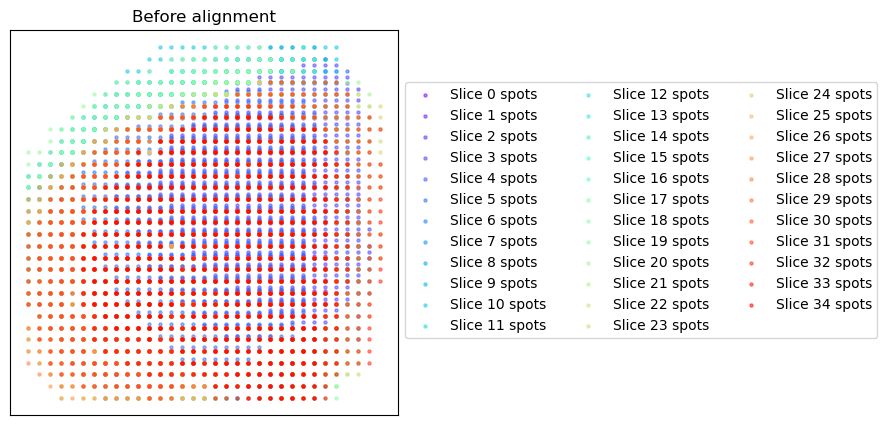

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


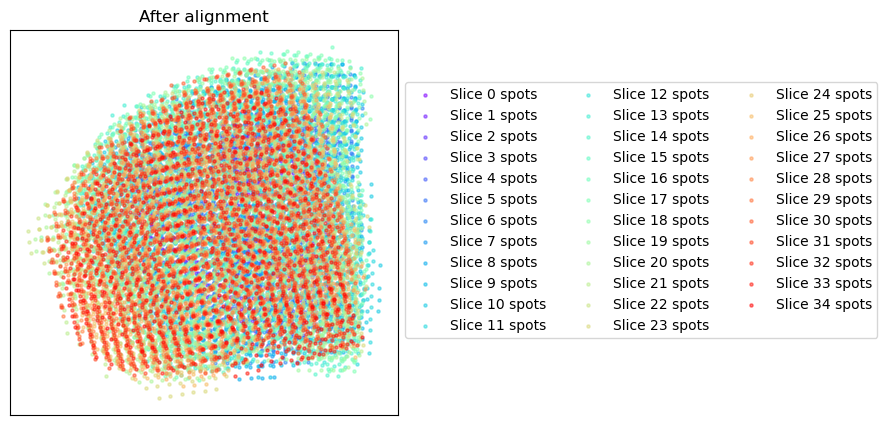

In [8]:
adata_st_list = nobatch.utils.align_spots(adata_st_list_raw,
                                           data_type = "ST",
                                           coor_key="loc_use",
                                           plot=True)

In [9]:
adata_st, adata_basis = nobatch.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col="sample",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=slice_dist_micron,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)

Finding highly variable genes...


6227 highly variable genes selected.
Calculate basis for deconvolution...
6 batches are used for computing the basis vector of cell type <Astro_AMY>.
6 batches are used for computing the basis vector of cell type <Astro_AMY_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_HPC>.
6 batches are used for computing the basis vector of cell type <Astro_HYPO>.
4 batches are used for computing the basis vector of cell type <Astro_STR>.
5 batches are used for computing the basis vector of cell type <Astro_THAL_hab>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_lat>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_med>.
6 batches are used for computing the basis vector of cell type <Astro_WM>.
4 batches are used for computing the basis vector of cell type <Endo>.
6 batches are used for computing the basis vector of cell type <Ext_Amy_1>.


In [10]:
model = nobatch.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=100)

  0%|          | 1/2000 [00:06<3:36:21,  6.49s/it]

Step: 0, Loss: 5119.6108, d_loss: 5114.2051, f_loss: 54.0564


  5%|▌         | 101/2000 [10:02<3:04:00,  5.81s/it]

Step: 100, Loss: 3834.7053, d_loss: 3831.9688, f_loss: 27.3653


 10%|█         | 201/2000 [21:41<3:28:43,  6.96s/it]

Step: 200, Loss: 3823.3083, d_loss: 3820.6038, f_loss: 27.0464


 15%|█▌        | 301/2000 [33:15<3:19:19,  7.04s/it]

Step: 300, Loss: 3819.0410, d_loss: 3816.3560, f_loss: 26.8500


 20%|██        | 401/2000 [45:31<3:07:48,  7.05s/it]

Step: 400, Loss: 3815.8831, d_loss: 3813.2107, f_loss: 26.7232


 25%|██▌       | 501/2000 [56:27<2:20:37,  5.63s/it]

Step: 500, Loss: 3813.7839, d_loss: 3811.1216, f_loss: 26.6244


 30%|███       | 601/2000 [1:07:34<2:32:19,  6.53s/it]

Step: 600, Loss: 3813.2112, d_loss: 3810.5500, f_loss: 26.6111


 35%|███▌      | 701/2000 [1:19:04<2:30:27,  6.95s/it]

Step: 700, Loss: 3811.1897, d_loss: 3808.5383, f_loss: 26.5125


 40%|████      | 801/2000 [1:30:31<2:18:03,  6.91s/it]

Step: 800, Loss: 3809.8911, d_loss: 3807.2461, f_loss: 26.4496


 45%|████▌     | 901/2000 [1:42:02<1:55:47,  6.32s/it]

Step: 900, Loss: 3809.0474, d_loss: 3806.4067, f_loss: 26.4070


 50%|█████     | 1001/2000 [1:51:53<1:37:40,  5.87s/it]

Step: 1000, Loss: 3811.4338, d_loss: 3808.7937, f_loss: 26.4016


 55%|█████▌    | 1101/2000 [2:02:52<1:44:07,  6.95s/it]

Step: 1100, Loss: 3808.1970, d_loss: 3805.5581, f_loss: 26.3898


 60%|██████    | 1201/2000 [2:14:35<1:26:32,  6.50s/it]

Step: 1200, Loss: 3810.7222, d_loss: 3808.0867, f_loss: 26.3547


 65%|██████▌   | 1301/2000 [2:25:37<1:18:06,  6.70s/it]

Step: 1300, Loss: 3806.3818, d_loss: 3803.7478, f_loss: 26.3405


 70%|███████   | 1401/2000 [2:36:02<57:56,  5.80s/it]  

Step: 1400, Loss: 3805.4900, d_loss: 3802.8625, f_loss: 26.2745


 75%|███████▌  | 1501/2000 [2:45:59<50:13,  6.04s/it]  

Step: 1500, Loss: 3805.9399, d_loss: 3803.3135, f_loss: 26.2657


 80%|████████  | 1601/2000 [2:55:46<38:37,  5.81s/it]

Step: 1600, Loss: 3804.7427, d_loss: 3802.1179, f_loss: 26.2464


 85%|████████▌ | 1701/2000 [3:05:30<28:34,  5.73s/it]

Step: 1700, Loss: 3812.9636, d_loss: 3810.3286, f_loss: 26.3498


 90%|█████████ | 1801/2000 [3:15:12<19:14,  5.80s/it]

Step: 1800, Loss: 3803.3403, d_loss: 3800.7185, f_loss: 26.2183


 95%|█████████▌| 1901/2000 [3:25:28<10:26,  6.33s/it]

Step: 1900, Loss: 3805.9209, d_loss: 3803.2981, f_loss: 26.2273


100%|██████████| 2000/2000 [3:35:51<00:00,  6.48s/it]


In [11]:
save_path = "./results/brain/no_batch"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)

In [12]:
# save adata_st
model.adata_st.write_h5ad(save_path + "/model.adata_st.h5ad")

In [13]:
adata_st_all = ad.AnnData(X = count.values)

adata_st_all.obs.index = count.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = count.columns

sc.pp.filter_cells(adata_st_all, min_genes=1)

In [14]:
adata_st_list = []

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

for i in range(len(slice_use)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index==slice_use[i]]
    adata_st_i.obs.index = adata_st_i.obs.index + '-slice%d' % i
    adata_st_i.obs['section_id'] = i
    adata_st_list.append(adata_st_i)

In [15]:

latent = pd.read_csv(save_path+'/representation.csv', index_col=0)

adata_all = ad.concat([adata_st_list[i] for i in range(len(slice_use))], index_unique=None)
adata_all_raw = adata_all.copy()

adata_all = adata_all[latent.index]
adata_all_raw = adata_all_raw[latent.index]

In [20]:
adata_all

AnnData object with n_obs × n_vars = 17086 × 23371
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'n_genes', 'section_id', 'louvain'
    uns: 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

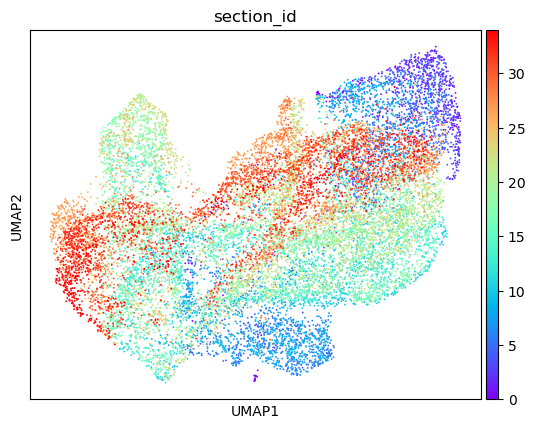

In [16]:
adata_all.obsm['latent'] = np.array(latent.values)

sc.pp.neighbors(adata_all, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata_all)
sc.pl.umap(adata_all, color="section_id", color_map="rainbow")

In [17]:
latent

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
01A_20.48x20.11-slice0,22.183298,5.462454,16.170784,-10.113573,7.804084,-6.642511,-9.161472,-7.529630,-2.355661,5.741127,...,-6.782597,-0.571735,18.702242,-5.611877,-5.106176,-9.743188,7.200512,-13.002501,-6.924112,-5.908913
01A_21.45x20.11-slice0,22.297653,6.057236,15.861489,-9.938808,7.823635,-6.619648,-8.665552,-7.868511,-0.450423,6.891848,...,-6.758827,-1.116619,18.495077,-5.774881,-5.385960,-9.516949,7.112472,-12.675097,-6.961337,-5.864818
01A_19.34x20.15-slice0,22.218166,5.472917,16.351517,-10.402447,7.012790,-6.683725,-9.293698,-7.454404,-2.170068,4.298800,...,-6.864559,-0.491238,19.316685,-5.257409,-5.628673,-10.134256,6.554497,-13.240678,-7.419076,-5.871006
01A_18.37x20.18-slice0,21.791933,4.875753,15.456826,-9.712872,7.106027,-6.750652,-8.890383,-7.687421,-0.201671,7.075146,...,-6.551452,-1.224201,18.015705,-5.533020,-5.250355,-9.830568,5.979162,-12.933661,-6.814230,-5.404406
01A_21.44x21.14-slice0,24.602901,7.284022,16.373040,-10.876617,8.571602,-6.828483,-9.990116,-8.983079,-0.556406,6.460590,...,-6.617312,-2.316639,20.358673,-4.571287,-6.531877,-9.479654,8.511017,-13.016010,-7.927663,-6.295513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35A_14.81x29.15-slice34,31.199780,0.284369,23.958374,-14.565947,3.355093,-8.271261,-16.220400,-12.022644,15.240176,2.192199,...,-3.401028,0.016264,28.144417,-3.753086,-10.095555,-11.037613,3.248234,-15.927960,-9.039719,-8.667520
35A_9.87x29.15-slice34,31.886215,1.550982,24.232021,-15.077992,4.674863,-8.712372,-16.047367,-11.731603,14.846311,3.664861,...,-3.961613,-0.259078,28.030550,-3.951664,-9.852396,-10.798998,3.784744,-16.335484,-9.802797,-8.846049
35A_23.97x29.15-slice34,29.679771,-3.070600,24.461302,-13.807482,3.487882,-7.439773,-14.802915,-11.449398,16.981890,-0.104620,...,-2.092918,1.099336,26.657476,-4.787680,-9.105594,-10.334146,2.130089,-15.832805,-7.338081,-8.380236
35A_11.99x29.18-slice34,31.720818,0.830224,25.034824,-15.464695,4.118171,-8.553268,-16.648941,-11.789464,15.865769,3.637777,...,-3.802741,0.251168,28.063828,-4.502455,-9.784469,-11.554536,3.261693,-17.170856,-9.419560,-8.897844


In [38]:

sc.tl.louvain(adata_all, resolution=0.4)

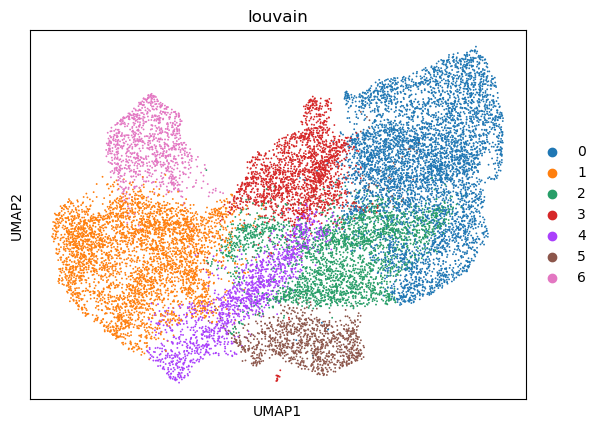

In [43]:
sc.pl.umap(adata_all, color="louvain",  color_map="rainbow")

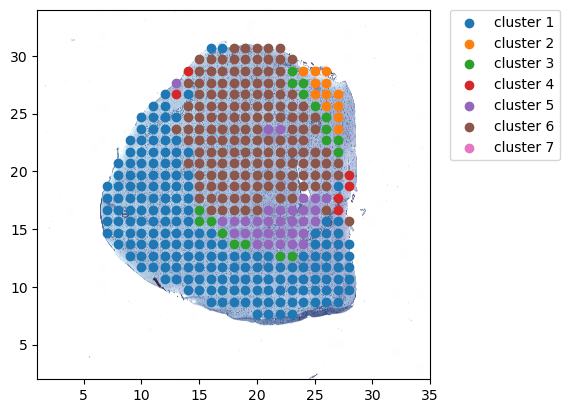

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459928_HE_06B.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
background = np.flipud(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "06B"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(7):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1]+2, label=f"cluster {i+1}")

# Match the background image
ax.imshow(background, extent=[1, 35, 2, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

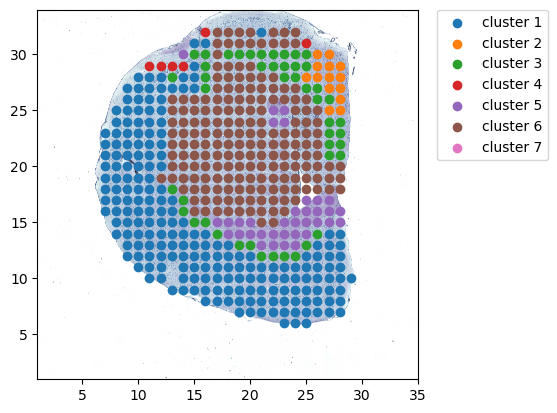

In [58]:

fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459929_HE_07A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "07A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(7):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1]  , label=f"cluster {i+1}")

# Match the background image
ax.imshow(background, extent=[1, 35, 1, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

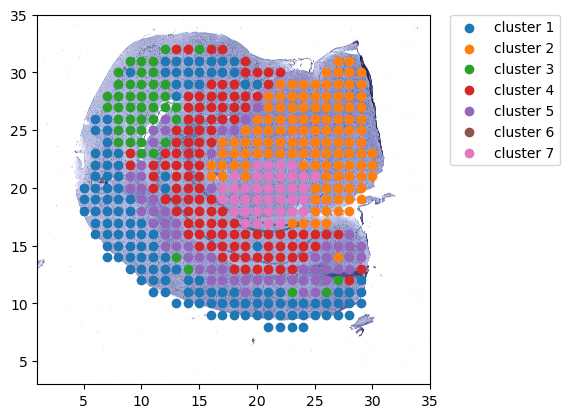

In [56]:

fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459964_HE_25A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)
#background = np.fliplr(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "25A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(7):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1] +2, label=f"cluster {i+1}")



# Match the background image
ax.imshow(background, extent=[1, 35, 3, 35])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

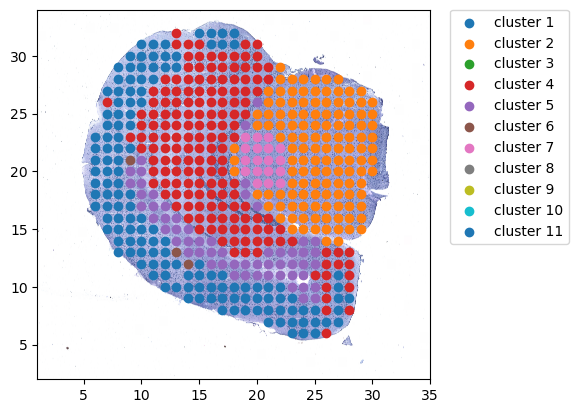

In [47]:

fig, ax = plt.subplots()
background = plt.imread("./data/brain_figure/GSM4459967_HE_27A.jpg")
# Filp 90 degree
background = np.rot90(background)
# Mirror up-down
#background = np.flipud(background)
#background = np.fliplr(background)

adata_st_i = model.adata_st[adata_all.obs['section_index'] == "27A"]
adata_st_i.obs["louvain"] = adata_all[adata_st_i.obs_names, ].obs["louvain"]

for i in range(11):
    adata_slice_sub = adata_st_i[adata_st_i.obs['louvain'] == str(i)]
    ax.scatter(adata_slice_sub.obsm['loc_use'][:,0], adata_slice_sub.obsm['loc_use'][:,1] +1, label=f"cluster {i+1}")



# Match the background image
ax.imshow(background, extent=[1, 35, 2, 34])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)